In [1]:
import utils
import models
import numpy as np
import torch
import configs
import pgm_explainer as pe
from scipy.special import softmax
import pandas as pd
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import pandas as pd
import argparse
from tqdm import tqdm

def arg_parse():
    parser = argparse.ArgumentParser(description="Explainer arguments.")

    parser.add_argument(
            "--bmname", dest="bmname", help="Name of the benchmark dataset"
        )
    parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument(
            "--gpu",
            dest="gpu",
            action="store_const",
            const=True,
            default=False,
            help="whether to use GPU.",
        )
    parser.add_argument(
            "--node-start", dest="node_start", type=int, help="Index of starting node."
        )
    parser.add_argument(
            "--node-end", dest="node_end", type=int, help="Index of ending node."
        )
    parser.add_argument(
            "--num-perturb-samples", dest="num_perturb_samples", type=int, help="Number of perturbed sample using to generate explanations."
        )
    parser.add_argument(
            "--top-node", dest="top_node", type=int, help="Number of nodes in explanation."
        )
    parser.add_argument(
            "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
        )
    parser.add_argument(
            "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
        )
    parser.add_argument(
            "--output-dim", dest="output_dim", type=int, help="Output dimension"
        )
    parser.add_argument(
            "--num-gc-layers",
            dest="num_gc_layers",
            type=int,
            help="Number of graph convolution layers before each pooling",
        )
    parser.add_argument(
            "--bn",
            dest="bn",
            action="store_const",
            const=True,
            default=False,
            help="Whether batch normalization is used",
        )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
            "--method", dest="method", type=str, help="Method. Possible values: base, att."
        )
    parser.add_argument(
            "--nobias",
            dest="bias",
            action="store_const",
            const=False,
            default=True,
            help="Whether to add bias. Default to True.",
        )
    
        # Explainer
   
    

    parser.set_defaults(
            ckptdir=None,
            dataset="syn1",
            opt="adam",  
            opt_scheduler="none",
            lr=0.1,
            clip=2.0,
            batch_size=20,
            num_epochs=100,
            hidden_dim=20,
            output_dim=20,
            num_gc_layers=3,
            method="base",
            dropout=0.0,
            node_start = None,
            node_end = None,
            num_perturb_samples = 100,
            top_node = None
        )
    
    return parser

d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prog_args = arg_parse()
args= prog_args.parse_args(['--dataset','syn1','--num-perturb-samples', '900','--top-node', '3'])

In [3]:
# Load model
A, X = utils.load_XA(args.dataset, datadir = "../Generate_XA_Data/XAL")
L = utils.load_labels(args.dataset, datadir = "../Generate_XA_Data/XAL")
print("A type: ", type(A))
num_classes = max(L) + 1
input_dim = X.shape[1]
num_nodes = X.shape[0]
ckpt = utils.load_ckpt(args)

print("input dim: ", input_dim, "; num classes: ", num_classes)
    
model = models.GcnEncoderNode(
        input_dim=input_dim,
        hidden_dim=args.hidden_dim,
        embedding_dim=args.output_dim,
        label_dim=num_classes,
        num_layers=args.num_gc_layers,
        bn=args.bn,
        args=args,
        )
model.load_state_dict(ckpt["model_state"]) 
pred = ckpt["save_data"]["pred"]

A type:  <class 'numpy.ndarray'>
loading model
../Train_GNN_model/ckpt\syn1.pth.tar
=> loading checkpoint '../Train_GNN_model/ckpt\syn1.pth.tar'
input dim:  10 ; num classes:  4


In [4]:
import random
random.seed(21)

In [5]:
# Range of node to explain in this dataset is from 300 to 700
nodes_to_explain = list(range(400,700,5)) 

In [6]:
# Construct the explainer
explainer = pe.Node_Explainer(model, A, X, pred, 3)

Explainer settings
\ A dim:  (700, 700)
\ X dim:  (700, 10)
\ Number of layers:  3
\ Perturbation mode:  0
\ Print result:  1


In [7]:
import networkx as nx
import pylab as plt

def pgm_draw_nx(pgm_explanation):
    print("Draw pgm explaination using networkx")
    nx.draw(pgm_explanation, with_labels=True)
    plt.show()

def PGM_construct(pgm_explanation, target_name):
    loc = [(0, 0), (-5, -5), (5, -5), (5, 5), (-5,5)]
    pos = dict(zip(pgm_explanation.nodes(), loc))
    color_dict = dict(zip(range(pred.shape[2]), ['y','b','m','r']))
    color = [color_dict[ np.argmax(pred[0,int(node),:])] for node in pgm_explanation.nodes()]
    name_dict = [r'$A$',r'$B$',r'$C$',r'$D$',r'$E$']
    name = dict(zip(pgm_explanation.nodes(), name_dict))

    # gt_graph = nx.Graph()
    # gt_graph.add_nodes_from(pos.keys(), size=50)
    # edges_list = [('300', '301'),('301', '302'),('302', '300'),('303', '300'),('304', '300')]
    # gt_graph.add_edges_from(edges_list)

    # print("Ground truth explaination of node ", name[target_name])
    # figure1, ax1 = plt.subplots(figsize = (4,4))
    # ax1.axis('off')
    # nx.draw_networkx_nodes(gt_graph,pos,node_size=400,node_color= color)
    # nx.draw_networkx_edges(gt_graph,pos,
    #                     edgelist= edges_list,
    #                     width=2.0,alpha=1)
    # nx.draw_networkx_labels(gt_graph,pos,name,font_size=18, font_family = 'serif', font_weight = 'normal',
    #                         font_color = 'w')

    # # filename = 'view/motif_' + str(explained_node)+ '.jpg' 
    # # figure1.savefig(filename, dpi=90, bbox_inches='tight')

    print("PGM explaination of node ", name[target_name])

    figure2, ax = plt.subplots(figsize = (4,4))
    ax.axis('off')
    nx.draw_networkx_nodes(pgm_explanation,pos,node_size=400,node_color= color)
    nx.draw_networkx_edges(pgm_explanation,pos,
                        edgelist= pgm_explanation.edges,
                        connectionstyle='arc3, rad = 0.2',
                        width=2.0,alpha=0.8)
    nx.draw_networkx_labels(pgm_explanation,pos,name,font_size=18, font_family = 'serif', font_color = 'w')
    figure2.show()

    # filename = 'view/pgm_' + str(explained_node)+ '.jpg' 
    # figure2.savefig(filename, dpi=90, bbox_inches='tight')



--------------------------- Node 400 ---------------------------
Explaining node: 400


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\pgm_explainer.py:120: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  X_torch = torch.tensor([self.X], dtype=torch.float)


MK-blanket of target node: [400, 402, 401]
Generate the PGM
PGM Nodes:  ['402', '401', '400']
PGM Edges:  [('402', '400'), ('401', '400')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2341879552245572
Target's label is:  1
Probability that the target's label is 1 given ['402'] is 0.3086758950510819
Probability that the target's label is 1 given ['402', '401'] is 0.43162393162393164
Draw pgm explaination using networkx


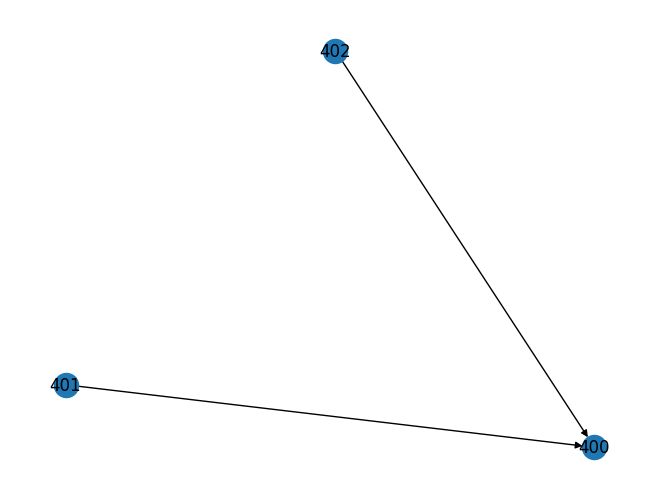

PGM explaination of node  $C$


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


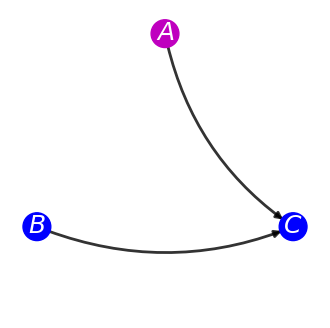

In [8]:
target = nodes_to_explain[0]

print(f"--------------------------- Node {target} ---------------------------")
# Explaining the target node
subnodes, data, stats = explainer.explain(target, num_samples = 900, top_node = 3, pred_threshold = 0.2)
# Markov Blanket of target node
print("MK-blanket of target node:", subnodes)

# Generating the Probabilistic Graph
print("Generate the PGM")
pgm_explanation = explainer.pgm_generate(target, data, stats, subnodes)
print("PGM Nodes: ", pgm_explanation.nodes())
print("PGM Edges: ", pgm_explanation.edges())

# Conversion of target names for preventing type mismatch
print("The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience")
target_name = str(target)
explaining_nodes = [node for node in pgm_explanation.nodes() if node != target_name]

# Computing marginal probability of target prediction with no observation
print("Compute marginal probability of the target prediction with no observation")
marginal_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, [])
print(marginal_prob)

# Computing other probabilities
target_label = np.argmax(pred[0,target])
print("Target's label is: ", target_label)
for num_of_evidence in range(len(explaining_nodes)):
    cond_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, explaining_nodes[0:num_of_evidence+1])
    print("Probability that the target's label is {} given {} is {}".format(target_label,
                                                                            explaining_nodes[0:num_of_evidence+1],
                                                                        cond_prob))


# Drawing pgm explanation
pgm_draw_nx(pgm_explanation)
PGM_construct(pgm_explanation, target_name)

In [9]:
# Functions to analyze the graph properties
def betweeness_centrality_single_sink(graph,node_to_explain, v):
    
    bc = 0
    diameter = nx.diameter(graph)
    nodes = list(graph.nodes())
    for i in tqdm(range(len(nodes))):
        paths_with_v = 0
        paths = 0
        if nodes[i]!=node_to_explain and nodes[i]!=v:
            # print(f"Centrality of {v} chosen node {i}")
            if nx.has_path(graph,nodes[i],node_to_explain):
                # Find all paths between i and the node_to_explain
                all_paths = nx.all_simple_paths(graph,nodes[i],node_to_explain,diameter)
                # print("All paths obtained")

                # Find the paths containing v
                for path in all_paths:
                    # print("loop entered")
                    # print(paths)
                    paths += 1
                    if v in path:
                        paths_with_v += 1

                # Add this to bc
                bc += paths_with_v/paths
    
    return bc

def normalize(A):
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

def centrality(G, stats,node_to_explain,variation=1,p_threshold=0.05):
    
    # # Obtain the importance score for all nodes
    # bc = {}
    # for v in list(G.nodes()):
    #     print(f"Calculating centrality for {v}")
    #     if v!=node_to_explain:
    #         bc.update({v : betweeness_centrality_single_sink(G,node_to_explain, v)})
    
    # bc.update({node_to_explain: 1})
    # bc ={}
    if variation==1:
        bc = nx.betweenness_centrality(G)
    elif variation==2:
        sources = [node_to_explain]
        targets = [v for v in list(G.nodes()) if v!=node_to_explain]
        bc = nx.betweenness_centrality_subset(G,sources,targets)


    print(bc)
    # Get the two vectors we have to compare for coherence calculation
    # We are fixing the values as 0 for the nodes not in "nodes_to_consider"
    A1 = []
    B1 = []
    for i in list(G.nodes()):
        A1.append(bc.get(i))
        B1.append(1 - (stats.get(i)))

    A1 = normalize(np.array(A1))
    B1 = normalize(np.array(B1))
    # print(f"A1: {len(A1)}")
    # print(f"B1: {len(B1)}")
    # return 1
    # Calculating coherence
    diff = np.subtract(np.array(A1), np.array(B1))
    if(np.array_equal(A1,B1) == False):
        return 1/(np.linalg.norm(diff,2))**2
    else:
        return 1

def graph_prop(graph, stats, target, p_threshold,variation):
    v = graph.number_of_nodes()
    e = graph.number_of_edges()
    avg_degree = float('%.3f'%(2*e/v))
    diameter = nx.diameter(graph)
    sparsity = float('%.3f'%(2*e/(v*(v-1))))
    coherence_int = float('%.3f'%(centrality(graph,stats, target, variation, p_threshold)))

    return [v,e,avg_degree,diameter,sparsity,coherence_int]

In [10]:
# Check the node mask obtained
# "stats" has the n-hop neighbors of the target node and the corresponding p-values
# The dependent neighbors are chosen based on comparing the p-value to a certain threshold
# For this reason we use the p-values as an indicator of importance of the node
# We define node_importance_by_exp = (1-p)

graph_data = []
variation = 1

# Explaining each target node
for target in nodes_to_explain:
    # Explaining the target node
    p_threshold = 0.05  # Default threshold for p-value according to statistics

    # We set top_node as None since we want to check how compact the explanations are without restricting its size
    _, _, stats = explainer.explain(target, num_samples = 900, p_threshold=p_threshold, pred_threshold = 0.2)

    # Original network
    G = nx.from_numpy_array(explainer.A)
    # Considered neighbors
    nbors = list(stats.keys())
    # nodes_to_consider = []
    # # Masking the nodes
    # for v in nbors:
    #     if stats.get(v) < p_threshold:
    #         nodes_to_consider.append(v)

    # Vertex induced subgraph that acts as the explanation
    exp_subgraph = nx.induced_subgraph(G, nbors)

    # All properties obtained
    graph_data.append(graph_prop(exp_subgraph,stats, target, p_threshold,variation))

# Convert the above data into a data frame
df = pd.DataFrame(graph_data, columns=["Order","Size","Average Degree","Diameter","Sparsity","Coherence"])

df.describe()

Explaining node: 400
{1: 0.001613946947683046, 3: 0.010223791520319022, 5: 0.033959846477833705, 6: 0.06220129068797559, 7: 0.01307469634154752, 8: 0.06584763992603683, 9: 0.20621010625409344, 10: 0.019702714511807756, 11: 0.06977366144406245, 12: 0.024110941340446227, 14: 0.011729669531634367, 15: 0.014338395882890197, 16: 0.11377179691249432, 17: 0.01104799238371441, 18: 0.02208815441072772, 20: 0.011165764511302686, 21: 0.005513534664945318, 22: 0.10445105205601989, 24: 0.19453551725412532, 25: 0.005091395212523653, 26: 0.005800775983393034, 28: 0.006833399327233604, 29: 0.0028789046946729353, 31: 0.01858365657242054, 32: 0.005007042633117251, 33: 0.01165894486989385, 34: 0.008515120818801512, 35: 0.007675048448725116, 36: 0.0010106537642623845, 37: 0.004339262873471116, 39: 0.003712564315690579, 42: 0.005598536253162357, 44: 0.0007191540842729998, 51: 0.01700186686923601, 52: 0.006919186594813298, 55: 0.03837025982016996, 57: 0.009036902137064384, 58: 0.00825989667603816, 60: 0.095

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.058767,0.078183
std,36.649724,180.849454,1.020604,0.375823,0.010257,0.022297
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.031000
25%,86.750000,263.500000,5.933250,5.000000,0.050000,0.061750
50%,121.000000,401.000000,6.715500,5.000000,0.058500,0.079000
75%,144.000000,542.250000,7.465500,5.000000,0.065250,0.094000
max,208.000000,864.000000,8.368000,6.000000,0.083000,0.132000


In [11]:
# Normalize the Coherence
coh_int = list(df["Coherence"])
coh = [float(i)/max(coh_int) for i in coh_int]

df = df.replace(coh_int, coh)
df.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.259218,0.592298
std,36.649724,180.849454,1.020604,0.375823,0.220639,0.168913
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.234848
25%,86.750000,263.500000,5.933250,5.000000,0.053750,0.467803
50%,121.000000,401.000000,6.715500,5.000000,0.074000,0.598485
75%,144.000000,542.250000,7.465500,5.000000,0.473485,0.712121
max,208.000000,864.000000,8.368000,6.000000,0.628788,1.000000


In [12]:
# Check the node mask obtained
# "stats" has the n-hop neighbors of the target node and the corresponding p-values
# The dependent neighbors are chosen based on comparing the p-value to a certain threshold
# For this reason we use the p-values as an indicator of importance of the node
# We define node_importance_by_exp = (1-p)

graph_data1 = []
variation = 2

# Explaining each target node
for target in nodes_to_explain:
    # Explaining the target node
    p_threshold = 0.05  # Default threshold for p-value according to statistics

    # We set top_node as None since we want to check how compact the explanations are without restricting its size
    _, _, stats = explainer.explain(target, num_samples = 900, p_threshold=p_threshold, pred_threshold = 0.2)

    # Original network
    G = nx.from_numpy_array(explainer.A)
    # Considered neighbors
    nbors = list(stats.keys())
    # nodes_to_consider = []
    # # Masking the nodes
    # for v in nbors:
    #     if stats.get(v) < p_threshold:
    #         nodes_to_consider.append(v)

    # Vertex induced subgraph that acts as the explanation
    exp_subgraph = nx.induced_subgraph(G, nbors)

    # All properties obtained
    graph_data1.append(graph_prop(exp_subgraph,stats, target, p_threshold,variation))

# Convert the above data into a data frame
df1 = pd.DataFrame(graph_data, columns=["Order","Size","Average Degree","Diameter","Sparsity","Coherence"])

df1.describe()

Explaining node: 400
{1: 0.0, 3: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 16.916666666666664, 10: 0.0, 11: 0.0, 12: 0.0, 14: 0.0, 15: 0.0, 16: 11.875, 17: 0.0, 18: 0.0, 20: 0.0, 21: 0.0, 22: 9.75, 24: 17.041666666666668, 25: 0.0, 26: 0.0, 28: 0.0, 29: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 39: 0.0, 42: 0.0, 44: 0.0, 51: 0.0, 52: 0.0, 55: 4.375, 57: 0.0, 58: 0.0, 60: 74.5, 61: 0.0, 64: 0.0, 65: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 580: 0.0, 77: 0.0, 81: 0.0, 82: 0.0, 84: 0.0, 86: 0.0, 88: 0.0, 89: 0.0, 92: 0.0, 94: 0.0, 96: 0.0, 97: 0.0, 99: 0.0, 100: 0.0, 102: 0.0, 105: 0.0, 106: 0.0, 108: 0.0, 111: 4.125, 112: 0.0, 114: 0.0, 115: 0.0, 116: 0.0, 118: 2.4166666666666665, 119: 0.0, 120: 0.0, 122: 0.0, 125: 0.0, 126: 0.0, 129: 0.0, 130: 0.0, 645: 0.0, 134: 0.0, 136: 0.0, 139: 0.0, 140: 0.0, 142: 0.0, 144: 0.0, 147: 0.0, 149: 0.0, 154: 0.0, 155: 0.0, 157: 0.0, 158: 0.0, 160: 0.0, 161: 0.0, 166: 0.0, 168: 1.5833333333333335, 176: 0.

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.058767,0.078183
std,36.649724,180.849454,1.020604,0.375823,0.010257,0.022297
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.031000
25%,86.750000,263.500000,5.933250,5.000000,0.050000,0.061750
50%,121.000000,401.000000,6.715500,5.000000,0.058500,0.079000
75%,144.000000,542.250000,7.465500,5.000000,0.065250,0.094000
max,208.000000,864.000000,8.368000,6.000000,0.083000,0.132000


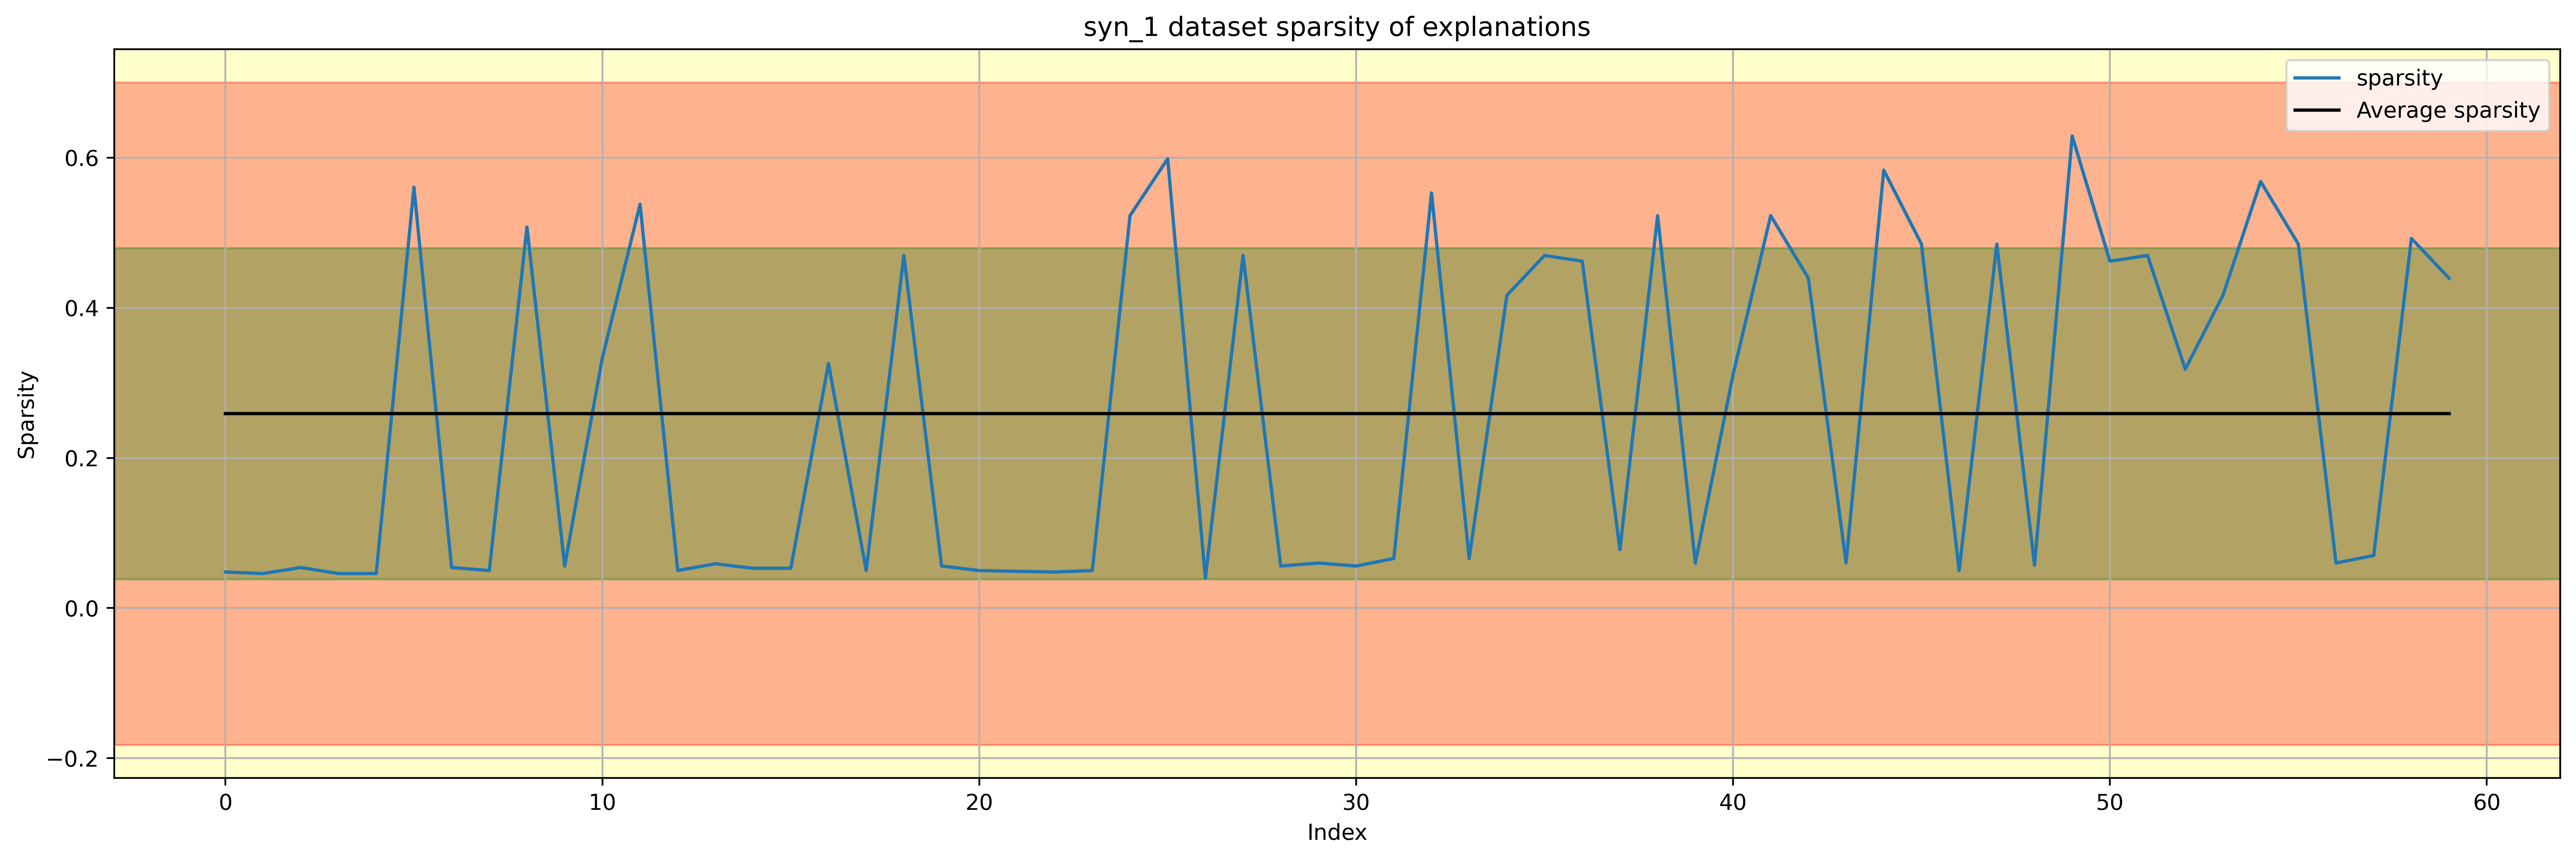

In [13]:
# Plot Sparsity
x = list(range(len(df)))
sparse = list(df['Sparsity'])
def_sparse = list(np.ones(len(df))*0.5)
mean_sparse = list(np.ones(len(df))*df['Sparsity'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, sparse, label='sparsity')
# plt.plot(x,def_sparse, label = 'Max edge density for sparse graphs')
plt.plot(x,mean_sparse, label = 'Average sparsity', color='k')

sp_mean = df['Sparsity'].mean()
sp_std = df['Sparsity'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_1 dataset sparsity of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Sparsity")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\plots\syn1_sparsity")
plt.show()

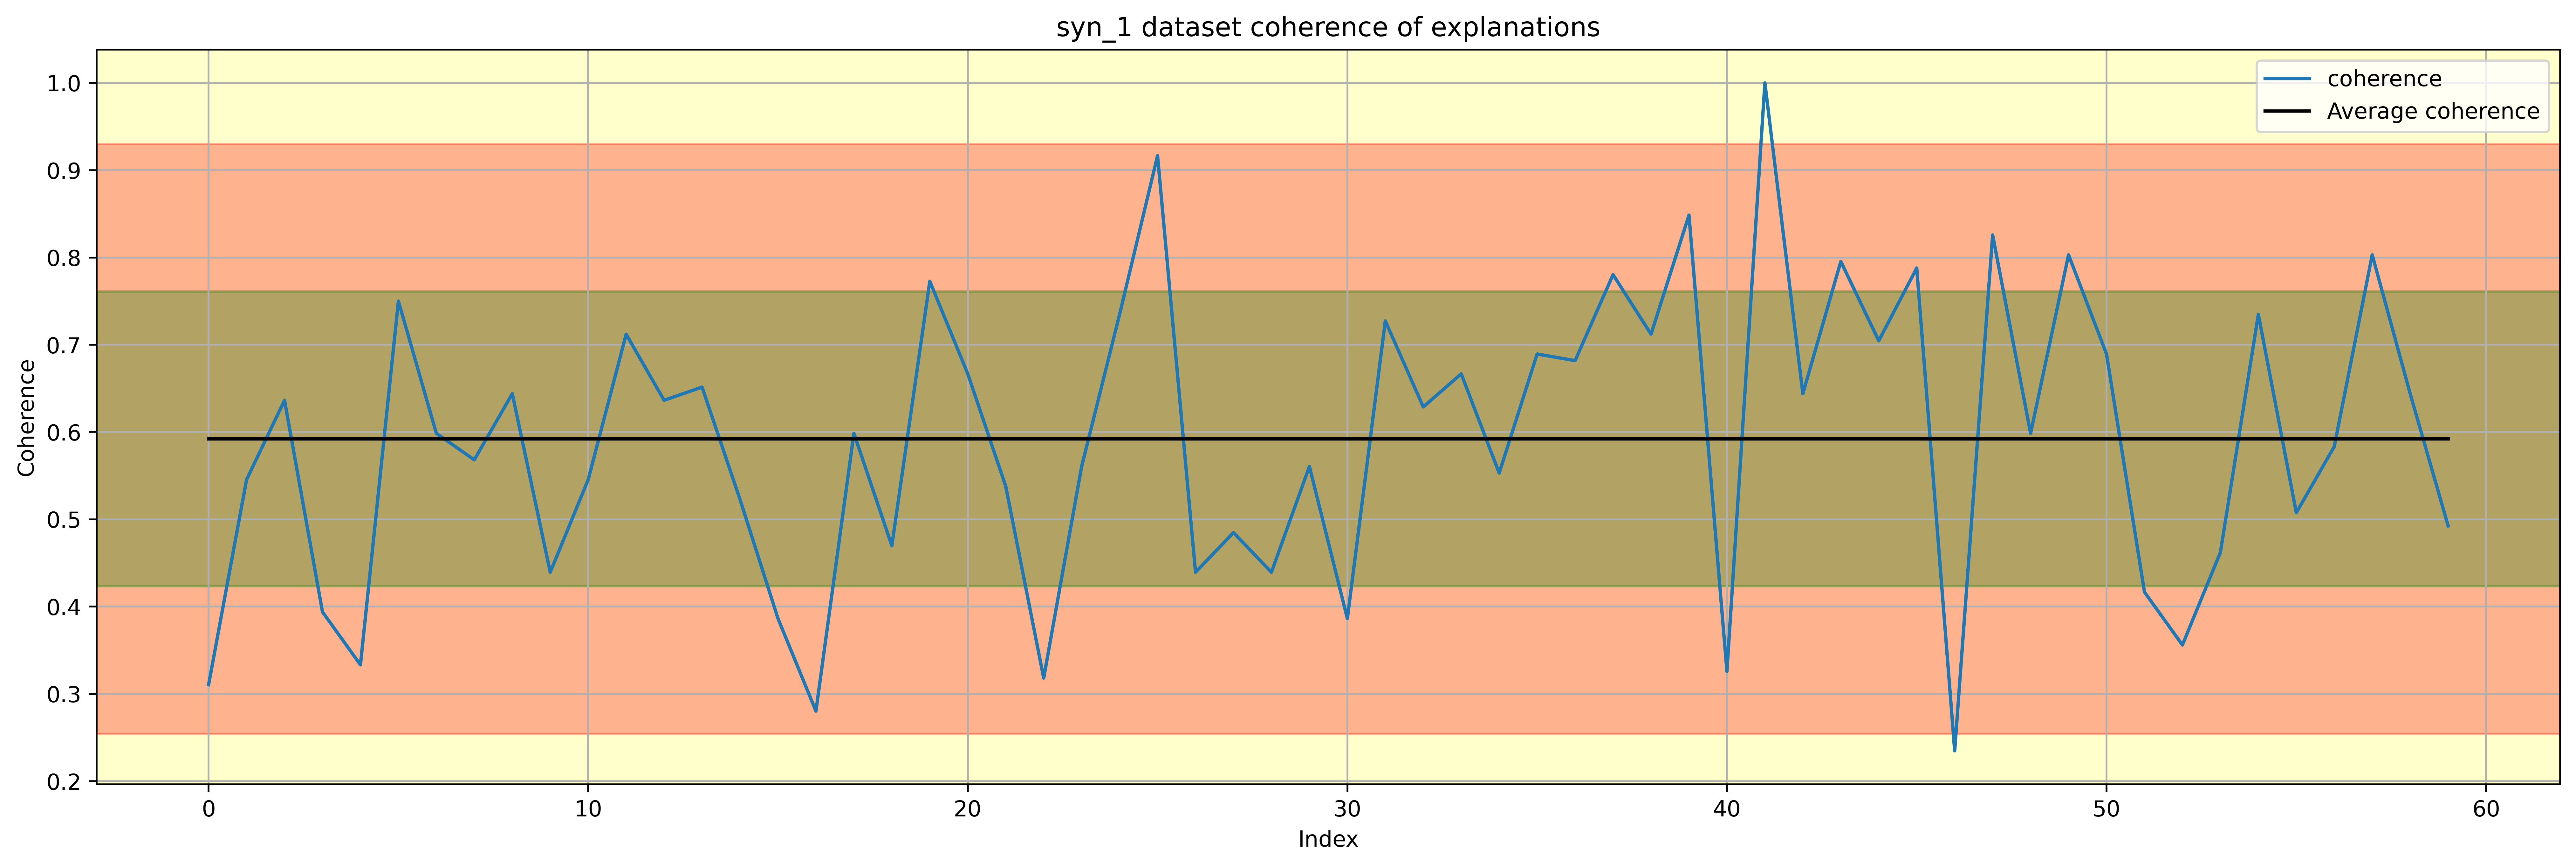

In [14]:
# Plot Coherence
coh = list(df['Coherence'])
mean_coh = list(np.ones(len(df))*df['Coherence'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, coh, label='coherence')
plt.plot(x,mean_coh, label = 'Average coherence', color='k')

coh_mean = df['Coherence'].mean()
coh_std = df['Coherence'].std()
y1 = coh_mean - coh_std
y_1 = y1 - coh_std
y2 = coh_mean + coh_std
y_2 = y2 + coh_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_1 dataset coherence of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Coherence")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\plots\syn1_coherence")
plt.show()